Gen   0  best mse=16653.57  avg mse=16746.77  best fitness=0.000060
Gen  20  best mse=16052.01  avg mse=16098.86  best fitness=0.000062
Gen  40  best mse=15728.57  avg mse=15765.95  best fitness=0.000064
Gen  60  best mse=15558.24  avg mse=15584.19  best fitness=0.000064
Gen  80  best mse=15440.99  avg mse=15453.72  best fitness=0.000065
Gen 100  best mse=15345.42  avg mse=15358.19  best fitness=0.000065
Gen 120  best mse=15257.59  avg mse=15273.92  best fitness=0.000066
Gen 140  best mse=15169.10  avg mse=15182.06  best fitness=0.000066
Gen 160  best mse=15079.10  avg mse=15091.46  best fitness=0.000066
Gen 180  best mse=14994.18  avg mse=15006.21  best fitness=0.000067
Gen 199  best mse=14918.41  avg mse=14929.62  best fitness=0.000067


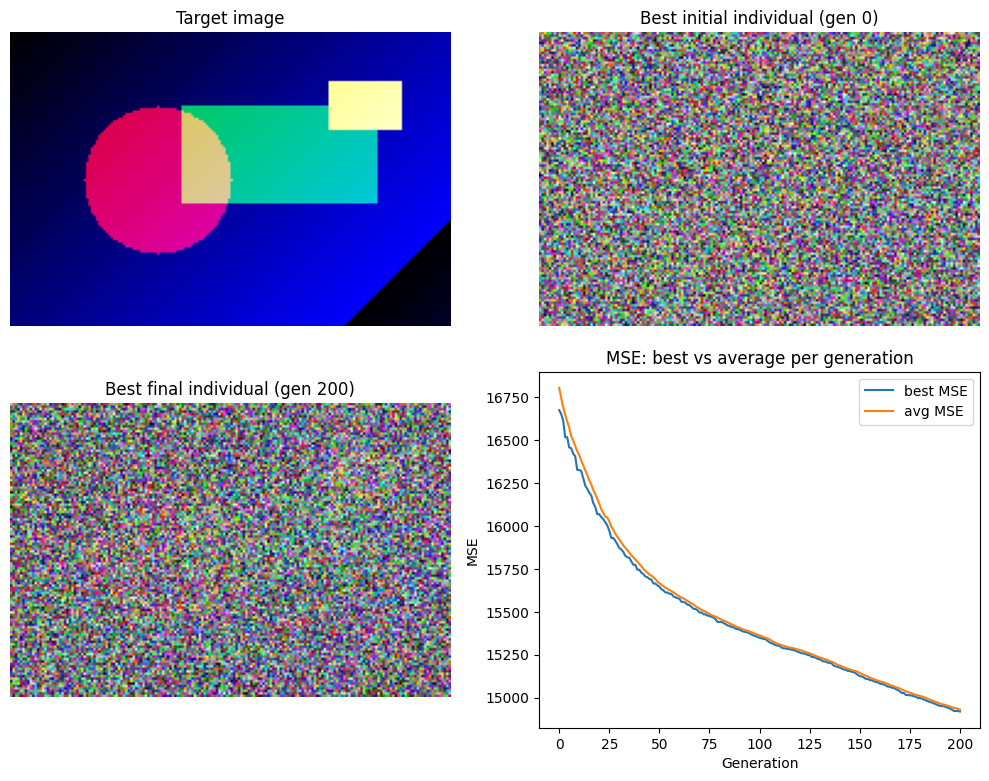

[Download the best evolved image](evolved_best.png)


In [2]:
# Genetic algorithm to evolve a population of images toward a target image.
# - Population: 50 images (120 x 180 x 3, values 0..255)
# - Fitness: negative MSE (we maximize fitness)
# - Selection: tournament selection (k=3)
# - Crossover: per-pixel mask from parents (mix pixels)
# - Mutation: random pixel changes in a small fraction of pixels per child
# We'll display the target image, best initial individual, best final individual, and fitness curve.
# This code runs here and shows results to you.

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import random

np.random.seed(42)
random.seed(42)

H, W = 120, 180
POP = 50
GENERATIONS = 200
TOURNAMENT_K = 3
MUTATION_PIXEL_PROB = 0.0005  # probability per pixel channel to mutate
ELITISM = 1  # keep best individual

# Create a target image (since you didn't upload one). We'll draw a simple colorful pattern:
def make_target(h, w):
    img = np.zeros((h, w, 3), dtype=np.uint8)
    y, x = np.indices((h, w))
    # red circle
    cx, cy = w//3, h//2
    r = min(h, w)//4
    mask = (x - cx)**2 + (y - cy)**2 <= r**2
    img[..., 0][mask] = 220
    # green rectangle
    img[h//4: h//4 + h//3, w//2 - 20: w//2 + 60, 1] = 200
    # blue diagonal gradient
    img[..., 2] = ((x + y) % 256).astype(np.uint8)
    # add a yellow small square
    img[h//6:h//6+20, w-50:w-20, 0:2] = 255  # red+green -> yellow
    return img

target = make_target(H, W)

# Initialize population: random images
population = np.random.randint(0, 256, size=(POP, H, W, 3), dtype=np.uint8)

def fitness_of(pop, target_img):
    # compute negative MSE per individual (we'll return positive fitness by negating MSE)
    # vectorized
    diff = pop.astype(np.int32) - target_img.astype(np.int32)
    mse = np.mean(diff**2, axis=(1,2,3))
    # convert to fitness: higher is better
    # use fitness = 1/(1+mse) could be used, but to keep dynamic range nicer use (max_possible - mse_sum)
    # We'll use fitness = 1 / (1 + mse) for numerical stability
    fitness = 1.0 / (1.0 + mse)
    return fitness, mse

# Selection: tournament
def tournament_select(pop, fitness, k=3):
    K = len(pop)
    idx = np.arange(K)
    chosen_indices = []
    for _ in range(K):
        competitors = np.random.choice(idx, size=k, replace=False)
        best = competitors[np.argmax(fitness[competitors])]
        chosen_indices.append(best)
    return np.array(chosen_indices, dtype=int)

# Crossover: per-pixel mask
def crossover(parent_a, parent_b):
    # mask of shape H,W,1 where True takes from parent_a
    mask = np.random.rand(H, W, 1) < 0.5
    child = np.where(mask, parent_a, parent_b)
    return child

# Mutation: random pixel-channel flips within small fraction
def mutate(child, mutation_prob):
    # create mask for channels
    shape = child.shape
    rand = np.random.rand(*shape)
    mask = rand < mutation_prob
    # random new values where mask is True
    if mask.any():
        new_values = np.random.randint(0, 256, size=shape, dtype=np.uint8)
        child = child.copy()
        child[mask] = new_values[mask]
    return child

# Run GA
best_history = []
avg_history = []
mse_best_history = []
mse_avg_history = []

# initial fitness
fitness, mse = fitness_of(population, target)
best_idx = np.argmax(fitness)
best_history.append(population[best_idx])
avg_history.append(np.mean(fitness))
mse_best_history.append(mse[best_idx])
mse_avg_history.append(np.mean(mse))

for gen in range(GENERATIONS):
    # selection
    sel_idx = tournament_select(population, fitness, k=TOURNAMENT_K)
    selected = population[sel_idx]
    # create new population via crossover
    children = np.empty_like(selected)
    i = 0
    while i < POP:
        parent1 = selected[i]
        if i+1 < POP:
            parent2 = selected[i+1]
        else:
            parent2 = selected[np.random.randint(0, POP)]
        child1 = crossover(parent1, parent2)
        child2 = crossover(parent2, parent1)
        # mutate children
        child1 = mutate(child1, MUTATION_PIXEL_PROB)
        child2 = mutate(child2, MUTATION_PIXEL_PROB)
        children[i] = child1
        if i+1 < POP:
            children[i+1] = child2
        i += 2
    # elitism: keep best individual
    best_old_idx = np.argmax(fitness)
    best_old = population[best_old_idx]
    # replace population with children
    population = children
    # place elite
    population[0] = best_old.copy()
    # evaluate
    fitness, mse = fitness_of(population, target)
    best_idx = np.argmax(fitness)
    best_history.append(population[best_idx].copy())
    avg_history.append(np.mean(fitness))
    mse_best_history.append(mse[best_idx])
    mse_avg_history.append(np.mean(mse))

    # print progress occasionally
    if gen % 20 == 0 or gen == GENERATIONS-1:
        print(f"Gen {gen:3d}  best mse={mse[best_idx]:.2f}  avg mse={np.mean(mse):.2f}  best fitness={fitness[best_idx]:.6f}")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(10,8))
ax = axes.ravel()

# target
ax[0].imshow(target)
ax[0].set_title("Target image")
ax[0].axis('off')

# best initial (from history index 0)
ax[1].imshow(best_history[0])
ax[1].set_title("Best initial individual (gen 0)")
ax[1].axis('off')

# best final
ax[2].imshow(best_history[-1])
ax[2].set_title(f"Best final individual (gen {GENERATIONS})")
ax[2].axis('off')

# fitness curve (plot MSE best and avg)
ax[3].plot(range(len(mse_best_history)), mse_best_history)
ax[3].plot(range(len(mse_avg_history)), mse_avg_history)
ax[3].set_title("MSE: best vs average per generation")
ax[3].set_xlabel("Generation")
ax[3].set_ylabel("MSE")
ax[3].legend(["best MSE", "avg MSE"])

plt.tight_layout()
plt.show()

# Expose the final best image as a file in /mnt/data for download
final_best = best_history[-1]
from PIL import Image
out_path = "evolved_best.png"
Image.fromarray(final_best).save(out_path)

print(f"[Download the best evolved image](evolved_best.png)")

